##GAN&CLIP&GA - RESNET (IMAGENET) EVALUATION

Authors: Maciej Domagała, Adam Komorowski

### GENERATING IMAGES

In [1]:
#@title Initialization (Installation, Imports) - check github branch!
%%capture
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt #imagenet_classes

!git clone https://github.com/maciejdomagala/clip_gans.git
%cd clip_gans
!git checkout evaluation ### WARNING!!!

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan pymoo kornia ftfy tensorboard

# IMPORTS
import warnings

import argparse
import os
import torch
import numpy as np
import pickle
import math
from tqdm import tqdm_notebook
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request
import cv2

from config import get_config
from problem import GenerationProblem
from operators import get_operators


warnings.filterwarnings('ignore')

In [3]:
# CHOOSE ONE OF THE IMAGENET CLASSES AND PASTE IN THE "TARGET" FIELD BELOW
with open("/content/imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]
print(categories)

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

In [2]:
#@title Input Parameters (Code will produce (population_size*number_of_loops) evaluation images)
target = "greenhouse" #@param {type:"string"}
config = "DeepMindBigGAN256" #@param ["DeepMindBigGAN256", "DeepMindBigGAN512", "StyleGAN2_ffhq_nod", "StyleGAN2_car_nod", "StyleGAN2_church_nod"]
generations = 50 #@param {type:"number"}
population_size = 64 #@param {type:"number"}
number_of_loops =  1#@param {type:"number"}
algorithm_param = 'ga' #@param ['ga', 'de']

In [3]:
#@title Config 
config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    tmp_folder="./results"
)
vars(config).update(get_config(config.config))
config.pop_size = population_size
config.algorithm = algorithm_param
config.generations = generations

if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)
if not os.path.exists(f'{config.tmp_folder}/{config.target}'): os.mkdir(f'{config.tmp_folder}/{config.target}')


In [4]:
#@title Support methods

def split_into_tiles_and_save(image):
  """
  Method splits batch image from the Pymoo output to the equal tiles and save them
  to the results directory.
  """
  global config, iteration, loop, target
  M = int(image.shape[0]//math.sqrt(config.pop_size))
  N = int(image.shape[1]//math.sqrt(config.pop_size))
  tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
  tiles = [tile for tile in tiles if tile.shape == (M,N,3)]
  if not os.path.exists(f'{config.tmp_folder}/{config.target}/{loop}'): os.mkdir(f'{config.tmp_folder}/{config.target}/{loop}')
  for j, each in enumerate(tiles):
    cv2.imwrite(f'./{config.tmp_folder}/{config.target}/{loop}/{target}_loop_{loop}_id_{j}.jpg', each)

def save_callback(algorithm):
    global config, iteration, loop, target

    iteration += 1

    sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
    X = np.stack([p.X for p in sortedpop])      
    ls = config.latent(config)
    ls.set_from_population(X)
    if iteration == config.generations:
      with torch.no_grad():
        generated = algorithm.problem.generator.generate(ls)
        name = f'batch_loop_{loop}.jpg'
        algorithm.problem.generator.save(generated, f"./{config.tmp_folder}/{config.target}/{name}")
        im = cv2.imread(f"./{config.tmp_folder}/{config.target}/{name}")
        split_into_tiles_and_save(im)

def generate_image(loop: int):
  problem = GenerationProblem(config)
  operators = get_operators(config)

  algorithm = get_algorithm(
      config.algorithm,
      pop_size=config.pop_size,
      sampling=operators["sampling"],
      crossover=operators["crossover"],
      mutation=operators["mutation"],
      eliminate_duplicates=True,
      callback=save_callback,
      **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=False,
  )

In [5]:
#@title RUN (GENERATE IMAGES)


for loop in tqdm_notebook(range(number_of_loops)):
  iteration=0
  generate_image(loop)

### RESNET - CLASS EVALUATION

In [6]:
#@title RESNET initialization
%%capture
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
model.eval()

import PIL
from torchvision import transforms

In [7]:
#@title RUN - EVALUATE CLASS
class_to_check = 'greenhouse' #@param {type:"string"}

with open("/content/imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

folders_to_check = [dI for dI in os.listdir(f'/content/clip_gans/{config.tmp_folder}/{class_to_check}') if os.path.isdir(os.path.join(f'/content/clip_gans/{config.tmp_folder}/{class_to_check}', dI))]
list_of_images = list()
for folder in folders_to_check:
  for (dirpath, dirnames, filenames) in os.walk(f'/content/clip_gans/{config.tmp_folder[2:]}/{class_to_check}/{folder}'):
      list_of_images += [os.path.join(dirpath, file) for file in filenames]

acc_count = 0
for image_path in tqdm_notebook(list_of_images):
  input_image = PIL.Image.open(image_path)
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)
  input_batch = input_batch.to('cuda')
  model.to('cuda')
  with torch.no_grad():
    output = model(input_batch)
  probabilities = torch.nn.functional.softmax(output[0], dim=0)

  top_prob, top_catid = torch.topk(probabilities, 1)
  predicted_label = categories[top_catid[0]]

  if predicted_label==class_to_check:
    acc_count += 1
  
print(f'\nAccuracy for {class_to_check.upper()} class: {round(acc_count/len(list_of_images)*100, 2)}%')
print(f'Number of evaluated images: {len(list_of_images)}')
print("")
print(f'Generation process summary:')
print(f'- Number of iterations per loop: {config.generations}')



Accuracy for GREENHOUSE class: 21.88%
Number of evaluated images: 64

Generation process summary:
- Number of iterations per loop: 50


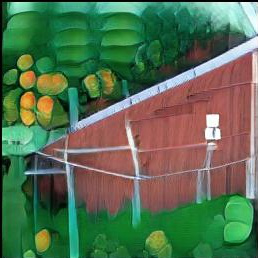

TOP 5 predicted categories:
confectionery 12.77%
barn 7.5%
tennis ball 5.69%
balloon 5.31%
grocery store 4.69%


In [9]:
#@title Single-photo evaluation (TOP-5 classes)
  
image_path = '/content/clip_gans/results/greenhouse/0/greenhouse_loop_0_id_1.jpg' #@param {type: "string"}
with open("/content/imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

input_image = PIL.Image.open(image_path)
display(input_image)
preprocess = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to('cuda')
model.to('cuda')
with torch.no_grad():
  output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

top_prob, top_catid = torch.topk(probabilities, 5)

print('TOP 5 predicted categories:')
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], f'{round(top5_prob[i].item()*100, 2)}%')